# Load dataset into a tensor

Unlike the first iteration, this one will use hourly data and use the change of pricing. This should allow for the network to work at any price scale as before it was having trouble using the full range of pricing history. Additionally, I am using a sliding window that does not stride its entire length. This could potentially cause prediction power as it is mixing the labels into features, but there is not enough hourly data to sufficiently isolate it.

In [25]:
import csv
import numpy as np
import json

START_OFFSET = 0

# 0 - 90 day gain
# 1 - 60 day gain
# 2 - 30 day gain
# 3 - 15 day gain
# 4 - 12 day gain
# 5 - 10 day gain
# 6 - 7 day gain
# 7 - 3 day gain
# 8 - Previous day close
# 9 - Previous day open
# 10 - Previous day high
# 11 - Previous day low
# 12 - Current day open
# 13 - P/E ratio
PRICE_INTERVAL = 30
STRIDE_INTERVAL = 1
print(f'PRICE: {PRICE_INTERVAL}\nSTRIDE: {STRIDE_INTERVAL}')

with open("spy_stock_history.json", "r") as historyfile:
    history = json.load(historyfile)['SPY']

def gain(history, index, days):    
    return (history[i]['open'] - history[i - days]['close']) / history[i - days]['close']
    
symbol_data = []
for i in range(START_OFFSET + 90, len(history)):
#     _90_day_gain = gain(history, i, 90)
#     _60_day_gain = gain(history, i, 60)
#     _30_day_gain = gain(history, i, 30)
#     _15_day_gain = gain(history, i, 15)
#     _12_day_gain = gain(history, i, 12)
#     _10_day_gain = gain(history, i, 10)
#     _7_day_gain = gain(history, i, 7)
#     _3_day_gain = gain(history, i, 3)
    previous_close = history[i-1]['close']
    previous_open = history[i-1]['open']
    previous_high = history[i-1]['high']
    previous_low = history[i-1]['low']
    current_open = history[i]['open']
#     pe_ratio = history[i]['pe']
    
    symbol_data.append(
        np.array([
#             _90_day_gain,
#             _60_day_gain,
#             _30_day_gain,
#             _15_day_gain,
#             _12_day_gain,
#             _10_day_gain,
#             _7_day_gain,
#             _3_day_gain,
            previous_close,
            previous_open,
            previous_high,
            previous_low,
            current_open,
#             pe_ratio
        ])
    )
original_data = symbol_data.copy()
NUM_OF_FEATURES = len(original_data[0])
print(f'NUM_OF_FEATURES: {NUM_OF_FEATURES}')
print(f'{len(symbol_data)} data points loaded')

PRICE: 30
STRIDE: 1
NUM_OF_FEATURES: 5
2428 data points loaded


## Batch Creation

In [26]:
NORMALIZE_DATA = False
OVERLAP_DATA = True
SCALE_RANGE = (8, 13)

def min_max_scale_series(series, target):
    data_flattened = np.array([day[SCALE_RANGE[0]:SCALE_RANGE[1]] for day in series]).flatten()
    min_of_price = data_flattened.min()
    max_of_price = data_flattened.max()
    std = data_flattened.std()
    scale = lambda x : (std * (x - min_of_price) / (max_of_price - min_of_price))
    adjusted_series = []
    for day in series:
        new_day = day.copy()
        for i in range(SCALE_RANGE[0], SCALE_RANGE[1]):
            new_day[i] = scale(new_day[i])
        adjusted_series.append(new_day)
    return adjusted_series, scale(target)

x = []
y = []
x_batch = []
for sale in original_data[:-365]:
    if len(x_batch) >= PRICE_INTERVAL:
        x_0 = x_batch
        y_0 = sale[-3]
        if NORMALIZE_DATA:
            x_0, y_0 = min_max_scale_series(x_batch, sale[-3])
        x.append(x_0)
        y.append(y_0)
        if OVERLAP_DATA:
            x_batch = x_batch[STRIDE_INTERVAL:]
            x_batch.append(sale)
        else:
            x_batch = []
    else:
        x_batch.append(sale)
x = np.array(x)
y = np.array(y)

permutation = np.random.permutation(x.shape[0])

x = x[permutation]
y = y[permutation]

x.shape

(2033, 30, 5)

In [27]:
import torch

TRAIN_SPLIT = int(0.8 * x.shape[0])
VALIDATION_SPLIT = int(0.9 * x.shape[0])

train_dataset = {
    'x': torch.tensor(x[:TRAIN_SPLIT]).float().cuda(),
    'y': torch.tensor(y[:TRAIN_SPLIT]).float().cuda()
}
validation_dataset = {
    'x': torch.tensor(x[TRAIN_SPLIT:VALIDATION_SPLIT]).float().cuda(),
    'y': torch.tensor(y[TRAIN_SPLIT:VALIDATION_SPLIT]).float().cuda()
}
test_dataset = {
    'x': torch.tensor(x[VALIDATION_SPLIT:]).float().cuda(),
    'y': torch.tensor(y[VALIDATION_SPLIT:]).float().cuda()
}

In [28]:
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import math

        
def init_weights(m):
    if isinstance(m, nn.LazyLinear) and isinstance(m, nn.LazyCon1d) and isinstance(m, nn.GRU):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

class MetaModel(nn.Module):
    def __init__(self, num_of_layers, hidden_size, seq_length, batch_size):
        super().__init__()
        
        self.__num_of_layers = num_of_layers
        self.__hidden_size = hidden_size
        
        self.conv = nn.Sequential(
            nn.LazyConv1d(128, 3, padding=1),
            nn.LazyBatchNorm1d(),
            nn.ELU(),
            nn.LazyConv1d(128, 3, padding=1),
            nn.LazyBatchNorm1d(),
            nn.ELU(),
            nn.LazyConv1d(128, 3, padding=1),
            nn.LazyBatchNorm1d(),
            nn.ELU(),
            nn.LazyConv1d(128, 3, padding=1),
            nn.LazyBatchNorm1d(),
            nn.ELU(),
            nn.MaxPool1d(1)
        )
        
        self.rnn = nn.LSTM(
            input_size=NUM_OF_FEATURES,
            num_layers=num_of_layers,
            hidden_size=hidden_size,
            batch_first=True,
            dropout=0.25
        )
        
        
        self.fc = nn.Sequential(
            nn.LazyLinear(4096),
            nn.LeakyReLU(),
            nn.LazyLinear(2048),
            nn.Dropout(0.1),
            nn.LeakyReLU(),
            nn.LazyLinear(1024),
            nn.LeakyReLU(),
            nn.LazyLinear(512),
            nn.Dropout(0.1),
            nn.LeakyReLU(),
            nn.LazyLinear(1)
        )
        
    def make_hidden(self, batch_size):
        return (Variable(torch.zeros(self.__num_of_layers, batch_size, self.__hidden_size)).cuda(),
                Variable(torch.zeros(self.__num_of_layers, batch_size, self.__hidden_size)).cuda())
        
    def forward(self, x, hidden = None):
        batch_size = x.shape[0]
        
        if hidden is None:
            hidden = self.make_hidden(batch_size)
        
        cnn_out = torch.permute(x, (0, 2, 1))
        cnn_out = self.conv(cnn_out)
        cnn_out = cnn_out.view(batch_size, -1)
        
        _, (rnn_out, _) = self.rnn(x, hidden)
        rnn_out = rnn_out.contiguous().view(batch_size, -1)
        
        x = torch.cat((cnn_out, rnn_out), 1)
        x = self.fc(x)
        
        return x.squeeze()

In [29]:
import torch.optim as optim
import torch.utils.data as data

torch.set_printoptions(sci_mode=False)

BATCH_SIZE = 32
SEQUENCE_LENGTH = train_dataset['x'].shape[1]
RNN_LAYERS = 6

model = MetaModel(RNN_LAYERS, 2048, SEQUENCE_LENGTH, BATCH_SIZE).cuda()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
# optimizer = optim.SGD(model.parameters(), lr=1e-5, momentum=0.9)
criterion = nn.MSELoss()
train_loader = data.DataLoader(data.TensorDataset(train_dataset['x'], train_dataset['y']),
                               shuffle=True, batch_size=BATCH_SIZE)
validation_loader = data.DataLoader(data.TensorDataset(validation_dataset['x'], validation_dataset['y']),
                                    shuffle=True, batch_size=BATCH_SIZE)
test_loader = data.DataLoader(data.TensorDataset(test_dataset['x'], test_dataset['y']),
                                    shuffle=True, batch_size=BATCH_SIZE)

with torch.no_grad():
    batch_x, batch_y = next(iter(train_loader))
    output = model(batch_x)
print(sum(p.numel() for p in model.parameters()))
model.apply(init_weights)

C:\Users\dpsim\miniconda3\envs\data-sci\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


261918081


MetaModel(
  (conv): Sequential(
    (0): Conv1d(5, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ELU(alpha=1.0)
    (6): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (7): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ELU(alpha=1.0)
    (9): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (10): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ELU(alpha=1.0)
    (12): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (rnn): LSTM(5, 2048, num_layers=6, batch_first=True, dropout=0.25)
  (fc): Sequential(
    (0): Linear(in_features=16128, out_features=4

In [30]:
import time
from torch.utils.tensorboard import SummaryWriter

EPOCHS=500
REPORT_INTERVAL = 50
best_validation = 1e9
writer = SummaryWriter(comment='Alabaster')

start_train = time.time()
for epoch in range(EPOCHS):
    start_epoch = time.time()
    
    # Do a training pass for all batches.
    model.train()
    train_error = 0
    train_loss = 0
    train_total = 0
    for batch_x, batch_y in train_loader:
        output = model(batch_x)
        loss = criterion(output, batch_y)
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()
        
        train_loss += np.sqrt(loss.item())
        train_error += torch.sum(torch.abs(output - batch_y))
        train_total += batch_x.shape[0]
    
    # Compute the RMSE and total average error
    train_rmse = train_loss / train_total
    train_terr = train_error / train_total
        
    writer.add_scalar("Loss/train", train_rmse, epoch)
    writer.add_scalar("Error/train", train_terr, epoch)
    
    # Validate the model on a new set.
    model.eval()
    with torch.no_grad():
        validation_loss = 0
        validation_error = 0
        validation_total = 0
        for batch_x, batch_y in validation_loader:
            output = model(batch_x)
            validation_error += torch.sum(torch.abs(output - batch_y))
            
            loss = criterion(output, batch_y)
            
            validation_loss += np.sqrt(loss.item())
            validation_total += batch_x.shape[0]
    
    # Compute the RMSE and total average error
    validation_rmse = validation_loss / validation_total
    validation_terr = validation_error / validation_total
    
    writer.add_scalar("Loss/validation", validation_rmse, epoch)
    writer.add_scalar("Error/validation", validation_terr, epoch)

    # Save the model if its better than the last one
    if validation_loss < best_validation:
        torch.save(model.state_dict(), 'best_daily_stock.pt')
        best_validation = validation_loss
        print(f"New best: {validation_rmse:.4f}")
    
    # Show results of the epoch.
    if epoch % REPORT_INTERVAL == 0:
        print(f'| epoch {epoch} => ' +
              f'train RMSE: {train_rmse:.4f} | '+
              f'train error: {train_terr:.4f} | '+
              f'validation RMSE: {validation_rmse:.4f} | ' +
              f'validation error: {validation_terr:.4f} | ' +
              f'{(time.time() - start_epoch):.2f} sec |')

train_duration = time.time() - start_train
train_sec = train_duration % 60
train_minutes = (train_duration // 60) % 60
train_hours = train_duration // 3600
print(f"Total train time: {train_hours:.0f}hr {train_minutes:.0f}min {train_sec:.0f}sec")

writer.flush()
writer.close()

New best: 0.4956
| epoch 0 => train RMSE: 3.9501 | train error: 116.5698 | validation RMSE: 0.4956 | validation error: 10.1542 | 24.22 sec |
New best: 0.3192
New best: 0.2092
New best: 0.1697
New best: 0.1589
| epoch 50 => train RMSE: 0.8615 | train error: 24.7052 | validation RMSE: 0.1792 | validation error: 4.2218 | 5.78 sec |
New best: 0.1367
New best: 0.1027
| epoch 100 => train RMSE: 0.5336 | train error: 14.8006 | validation RMSE: 0.5545 | validation error: 15.7068 | 5.78 sec |
New best: 0.0963
| epoch 150 => train RMSE: 0.5309 | train error: 14.8475 | validation RMSE: 0.2244 | validation error: 4.9176 | 5.76 sec |
New best: 0.0946
New best: 0.0860
| epoch 200 => train RMSE: 0.3884 | train error: 10.4522 | validation RMSE: 0.1523 | validation error: 3.5623 | 5.75 sec |
| epoch 250 => train RMSE: 0.3606 | train error: 9.7558 | validation RMSE: 0.1396 | validation error: 3.6086 | 5.58 sec |
| epoch 300 => train RMSE: 0.4074 | train error: 11.2643 | validation RMSE: 0.1177 | validat

# Results

All experiements were done over 500 epochs. Strongest validation model was picked and tested against a random test set.

> MCG-3 needs recompiled and saved.

| Trial | LR | RMSE | Error | Size | Train Time |
|:----|:---|:---|:--- |:---|:---|
| GRU Only | `0.001` |  `3.1324` | `67.4118` | `1.03 GB` | `00:48:07` |
| Conv+GRU (CoGr) | `0.001` | `3.1452` | `66.5887` | `521MB` | `00:22:49` |
| MultiConv + GRU (MCG) | `0.001` | `2.5979` | `53.5868` | `269MB` | `00:12:34` |
| MultiConv + LSTM (MCL-3) | `0.001` | `2.5609` | `53.2376` | `272MB` | `00:14:25` |
| Transformer | `0.001` | --- | --- | --- |
| MCG-3 | `0.001` | `2.2889` | `45.7506` | `271MB` | `00:14:57` |
| Bidirectional MCG-3 | `0.001` | `2.5024` | `54.8630` | `525MB` | `00:30:15` |
| MultiHead Attention + GRU | `0.01` | --- | --- | --- |
| Best + SGD | `0.01` | --- | --- | --- |

### MCG-3 Variant Training

0.9293 = 4 layers 1024 hidden 120 interval 121 stride 50 epochs

1.3071 = 3 layers 2048 hidden 60 interval 61 stride 50 epochs

1.3088 = 6 layers 2048 hidden 60 interval 61 stride 250 epochs

In [32]:
model.load_state_dict(torch.load('best_daily_stock.pt'))
model.eval()
with torch.no_grad():
    test_loss = 0
    test_error = 0
    test_total = 0
    for batch_x, batch_y in test_loader:
        output = model(batch_x)
        test_loss += np.sqrt(criterion(output, batch_y).item())
        test_error += torch.sum(torch.abs(output - batch_y))
        test_total += batch_x.shape[0]

    test_rmse = test_loss / test_total
    test_terr = test_error / test_total
    print(f'| Test => test RMSE: {test_rmse:.4f} | test error: {test_terr:.4f} |')

| Test => test RMSE: 0.0578 | test error: 1.3314 |


In [33]:
model.eval()
with torch.no_grad():
    batch_x, batch_y = next(iter(test_loader))
    output = model(batch_x)
    print(output)
    print(batch_y)

tensor([236.8564, 267.2738, 209.2885, 276.2993, 190.4349, 392.2451, 190.6295,
        242.1371, 274.1780, 319.8566, 271.0765, 265.8617, 277.4168, 287.6581,
        288.8036, 415.1951, 214.4035, 295.0106, 211.0646, 252.6481, 217.7507,
        218.6117, 467.5748, 199.5701, 479.1516, 273.5826, 210.6654, 452.5779,
        240.6851, 207.5086, 268.3471, 279.0815], device='cuda:0')
tensor([237.3100, 267.4377, 206.8100, 275.9800, 188.0400, 390.0700, 188.5000,
        241.8800, 274.2500, 320.2500, 266.6600, 265.6800, 276.9900, 289.9000,
        289.4900, 416.7400, 213.7800, 295.6300, 210.2500, 252.8900, 216.8700,
        216.0400, 469.6291, 196.6800, 479.9800, 271.6100, 208.2890, 451.6050,
        239.8700, 205.8500, 268.3850, 279.9100], device='cuda:0')


env: KMP_DUPLICATE_LIB_OK=TRUE
| Pred => error: 0.7766 |


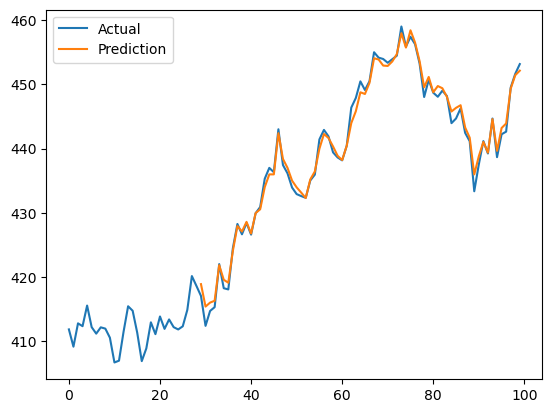

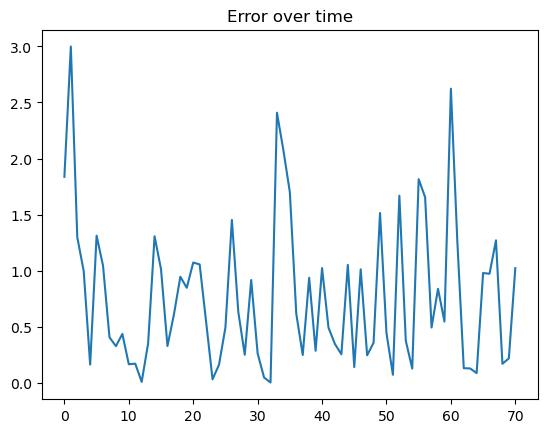

In [39]:
%env KMP_DUPLICATE_LIB_OK=TRUE

import matplotlib.pyplot as plt

%matplotlib inline

actual = []
errors = []

model.eval()
with torch.no_grad():
    model.eval()
    
    pred_loss = 0
    pred_error = 0
    pred_total = 0
    prediction = []
    batch = []
    for d in original_data[-100:]:
        actual.append(d[-1])
        batch.append(d)
        if len(batch) >= PRICE_INTERVAL:
            batch_t = torch.tensor([batch]).float().cuda()
            output = model(batch_t)
            output = output.cpu()
            
            errors.append(torch.sum(torch.abs(output - torch.tensor(d[-1]))))
            pred_error += errors[-1]
            pred_total += batch_t.shape[0]
            
            prediction.append(output.item())
            batch = batch[1:]

pred_terr = pred_error / pred_total
print(f'| Pred => error: {pred_terr:.4f} |')
            
actual = np.array(actual)
prediction = np.array(prediction)
x = np.arange(0, actual.shape[0], 1)

plt.plot(x, actual, label="Actual")
plt.plot(x[PRICE_INTERVAL-1:], prediction, label="Prediction")
plt.legend()
plt.show()

plt.plot(np.arange(0, len(errors), 1), errors, label="Errors")
plt.title("Error over time")
plt.show()

In [40]:
x = torch.randn(1, PRICE_INTERVAL, NUM_OF_FEATURES, requires_grad=True).cuda()
(h0, c0) = model.make_hidden(1)

output = model(x, (h0, c0))
torch.onnx.export(model,
                  (x, (h0, c0)),
                  "Alabaster.onnx",
                  export_params=True,
                  opset_version=10,
                  do_constant_folding=True,
                  input_names = ['input', 'h0', 'c0'],
                  output_names = ['output'])

C:\Users\dpsim\miniconda3\envs\data-sci\lib\site-packages\torch\onnx\symbolic_opset9.py:4476: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with LSTM can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or define the initial states (h0/c0) as inputs of the model. 
  warnings.warn(


================ Diagnostic Run torch.onnx.export version 2.0.1 ================
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



# Models

In [ ]:
class GruOnlyModel(nn.Module):
    def __init__(self, num_of_layers, hidden_size, seq_length, batch_size):
        super().__init__()
        
        self.__num_of_layers = num_of_layers
        self.__hidden_size = hidden_size
        
        self.rnn = nn.GRU(
            input_size=4,
            num_layers=num_of_layers,
            hidden_size=hidden_size,
            batch_first=True,
            dropout=0.2
        )
        
        self.fc = nn.Sequential(
            nn.LazyLinear(4096),
            nn.LazyBatchNorm1d(),
            nn.Dropout(0.2),
            nn.LazyLinear(1024),
            nn.LazyBatchNorm1d(),
            nn.Dropout(0.2),
            nn.LeakyReLU(),
            nn.LazyLinear(512),
            nn.Dropout(0.2),
            nn.LeakyReLU(),
            nn.LazyLinear(1)
        )
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.__num_of_layers, batch_size, self.__hidden_size).zero_()
        return hidden
        
    def forward(self, x, hidden):
        batch_size = x.shape[0]

        x, hidden = self.rnn(x, hidden)
        x = x.contiguous().view(batch_size, -1)
        
        x = self.fc(x)
        
        return (x.squeeze(), hidden)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
 
class ConvGruModel(nn.Module):
    def __init__(self, num_of_layers, hidden_size, seq_length, batch_size):
        super().__init__()
        
        self.__num_of_layers = num_of_layers
        self.__hidden_size = hidden_size
        
        self.conv = nn.LazyConv1d(16, 3, stride=2)
        
        self.rnn = nn.GRU(
            input_size=16,
            num_layers=num_of_layers,
            hidden_size=hidden_size,
            batch_first=True,
            dropout=0.2
        )
        
        self.fc = nn.Sequential(
            nn.LazyLinear(4096),
            nn.LazyBatchNorm1d(),
            nn.Dropout(0.2),
            nn.LazyLinear(1024),
            nn.LazyBatchNorm1d(),
            nn.Dropout(0.2),
            nn.LeakyReLU(),
            nn.LazyLinear(512),
            nn.Dropout(0.2),
            nn.LeakyReLU(),
            nn.LazyLinear(1)
        )
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.__num_of_layers, batch_size, self.__hidden_size).zero_()
        return hidden
        
    def forward(self, x, hidden):
        batch_size = x.shape[0]
        
        x = torch.permute(x, (0, 2, 1))
        x = self.conv(x)
        
        x = torch.permute(x, (0, 2, 1))
        x, hidden = self.rnn(x, hidden)
        x = x.contiguous().view(batch_size, -1)
        
        x = self.fc(x)
        
        return (x.squeeze(), hidden)

## MultiLayer Convolutional GRU Network

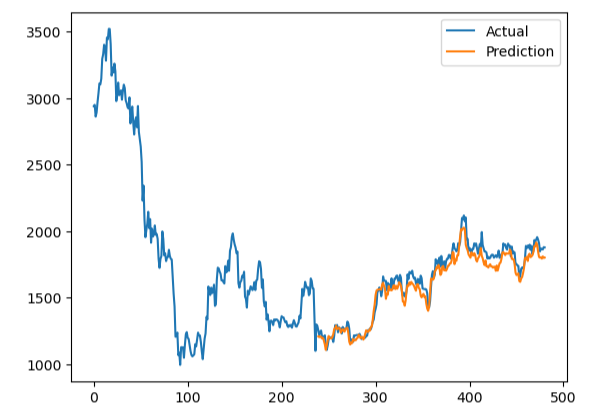

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
 
class MultiCnnGruModel(nn.Module):
    def __init__(self, num_of_layers, hidden_size, seq_length, batch_size):
        super().__init__()
        
        self.__num_of_layers = num_of_layers
        self.__hidden_size = hidden_size
        
        self.conv = nn.Sequential(
            nn.LazyConv1d(16, 3, stride=2),
            nn.LeakyReLU(),
            nn.LazyBatchNorm1d(),
            nn.LazyConv1d(32, 3, stride=2),
        )
        
        self.rnn = nn.GRU(
            input_size=32,
            num_layers=num_of_layers,
            hidden_size=hidden_size,
            batch_first=True,
            dropout=0.2
        )
        
        self.fc = nn.Sequential(
            nn.LazyLinear(4096),
            nn.LazyBatchNorm1d(),
            nn.Dropout(0.2),
            nn.LazyLinear(1024),
            nn.LazyBatchNorm1d(),
            nn.Dropout(0.2),
            nn.LeakyReLU(),
            nn.LazyLinear(512),
            nn.Dropout(0.2),
            nn.LeakyReLU(),
            nn.LazyLinear(1)
        )
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.__num_of_layers, batch_size, self.__hidden_size).zero_()
        return hidden
        
    def forward(self, x, hidden):
        batch_size = x.shape[0]
        
        x = torch.permute(x, (0, 2, 1))
        x = self.conv(x)
        
        x = torch.permute(x, (0, 2, 1))
        x, hidden = self.rnn(x, hidden)
        x = x.contiguous().view(batch_size, -1)
        
        x = self.fc(x)
        
        return (x.squeeze(), hidden)

## Multi-Convolutional 3 Layer GRU Network (MCG-3)

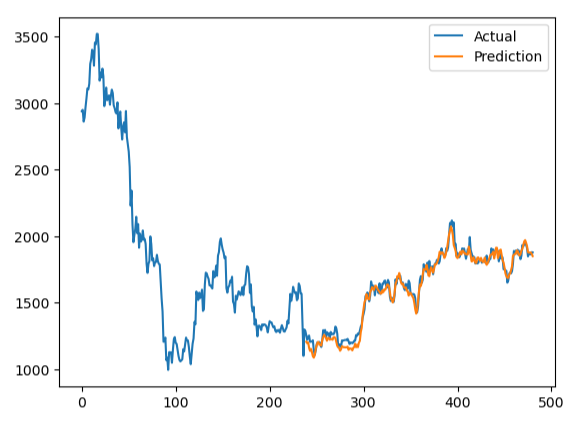

In [ ]:
class Mcg3Model(nn.Module):
    def __init__(self, num_of_layers, hidden_size, seq_length, batch_size):
        super().__init__()
        
        self.__num_of_layers = num_of_layers
        self.__hidden_size = hidden_size
        
        self.conv = nn.Sequential(
            nn.LazyConv1d(16, 3, stride=2),
            nn.LeakyReLU(),
            nn.LazyBatchNorm1d(),
            nn.LazyConv1d(32, 3, stride=2),
        )
        
        self.rnn = nn.GRU(
            input_size=32,
            num_layers=num_of_layers,
            hidden_size=hidden_size,
            batch_first=True,
            dropout=0.2
        )
        
        self.fc = nn.Sequential(
            nn.LazyLinear(4096),
            nn.LazyBatchNorm1d(),
            nn.Dropout(0.2),
            nn.LazyLinear(1024),
            nn.LazyBatchNorm1d(),
            nn.Dropout(0.2),
            nn.LeakyReLU(),
            nn.LazyLinear(512),
            nn.Dropout(0.2),
            nn.LeakyReLU(),
            nn.LazyLinear(1)
        )
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.__num_of_layers, batch_size, self.__hidden_size).zero_()
        return hidden
        
    def forward(self, x, hidden):
        batch_size = x.shape[0]
        
        x = torch.permute(x, (0, 2, 1))
        x = self.conv(x)
        
        x = torch.permute(x, (0, 2, 1))
        x, hidden = self.rnn(x, hidden)
        x = x.contiguous().view(batch_size, -1)
        
        x = self.fc(x)
        
        return (x.squeeze(), hidden)

In [329]:
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import math

        
def init_weights(m):
    if isinstance(m, nn.LazyLinear) and isinstance(m, nn.LazyCon1d) and isinstance(m, nn.GRU):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

class MetaModel(nn.Module):
    def __init__(self, num_of_layers, hidden_size, seq_length, batch_size):
        super().__init__()
        
        self.__num_of_layers = num_of_layers
        self.__hidden_size = hidden_size
        
        self.conv = nn.Sequential(
            nn.LazyConv1d(64, 3, padding=1),
            nn.LazyBatchNorm1d(),
            nn.ELU(),
            nn.LazyConv1d(64, 3, padding=1),
            nn.LazyBatchNorm1d(),
            nn.ELU(),
            nn.LazyConv1d(64, 3, padding=1),
            nn.LazyBatchNorm1d(),
            nn.ELU(),
            nn.LazyConv1d(64, 3, padding=1),
            nn.LazyBatchNorm1d(),
            nn.ELU(),
            nn.MaxPool1d(1)
        )
        
        self.rnn = nn.GRU(
            input_size=NUM_OF_FEATURES,
            num_layers=num_of_layers,
            hidden_size=hidden_size,
            batch_first=True,
            dropout=0.25
        )
        
        
        self.fc = nn.Sequential(
            nn.LazyLinear(4096),
            nn.LeakyReLU(),
            nn.LazyLinear(1024),
            nn.LeakyReLU(),
            nn.LazyLinear(512),
            nn.Dropout(0.1),
            nn.LeakyReLU(),
            nn.LazyLinear(1)
        )
        
    def forward(self, x):
        batch_size = x.shape[0]
        
        cnn_out = torch.permute(x, (0, 2, 1))
        cnn_out = self.conv(cnn_out)
        cnn_out = cnn_out.view(batch_size, -1)
        
        h_0 = Variable(torch.zeros(self.__num_of_layers, batch_size, self.__hidden_size)).cuda()
        _, rnn_out = self.rnn(x, h_0)
        rnn_out = rnn_out.contiguous().view(batch_size, -1)
        
        x = torch.cat((cnn_out, rnn_out), 1)
        x = self.fc(x)
        
        return x.squeeze()